convnet_999


In [1]:
# For reproducibility with CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

In [2]:
import re
import random
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, multilabel_confusion_matrix

import pickle
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
os.getcwd()

'/content'

In [5]:
import os

# Disable Colab’s automatic /kaggle/input caching
os.environ["KAGGLEHUB_DISABLE_COLAB_CACHE"] = "1"

import kagglehub

path = kagglehub.dataset_download("snikhilrao/chexlocalize-dataset")
print("Downloaded dataset path:", path)


100%|██████████| 2.83G/2.83G [00:21<00:00, 138MB/s]

Extracting files...


Downloaded dataset path: /root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1


In [ ]:
!pip install --upgrade kagglehub --quiet


In [6]:
!ls /root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1

chexlocalize_dataset


In [7]:
import os

root = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1"
for path, dirs, files in os.walk(root):
    if 'gradcam_maps_val' in path:
        print(path)
        break


/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val


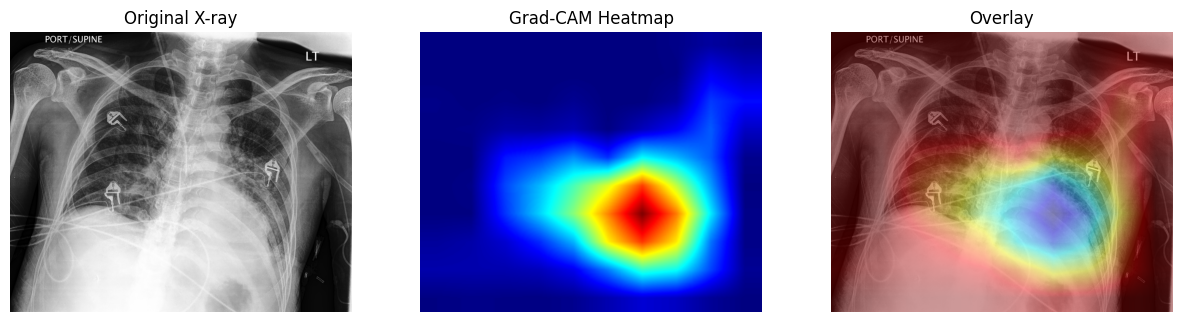

In [8]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt



# 1. paths
heatmap_folder =  "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"
image_folder = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1"
heatmap_file = "patient64669_study1_view1_frontal_Airspace Opacity_map.pkl"
image_file   = "view1_frontal.jpg"

pkl_path = os.path.join(heatmap_folder, heatmap_file)
img_path = os.path.join(image_folder, image_file)

# 2. load image
orig = cv2.imread(img_path)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# 3. load heatmap
with open(pkl_path, "rb") as f:
    data = pickle.load(f)

arr = next(iter(data.values())) if isinstance(data, dict) else data
arr = np.squeeze(np.array(arr))  # (1,1,320,320) -> (320,320)

# 4. normalize + color
arr_norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
arr_uint8 = (arr_norm * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(arr_uint8, cv2.COLORMAP_JET)

# 5. resize
heatmap_resized = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

# 6. overlay
overlay = cv2.addWeighted(orig, 0.6, heatmap_resized, 0.4, 0)

# 7. show everything
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(orig)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap_resized, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


In [12]:
import torch

checkpoint = torch.load("/content/convnet_seed_999_best_model.pth", map_location='cuda')

print(checkpoint["model_state_dict"].keys())


odict_keys(['features.0.0.weight', 'features.0.0.bias', 'features.0.1.weight', 'features.0.1.bias', 'features.1.0.layer_scale', 'features.1.0.block.0.weight', 'features.1.0.block.0.bias', 'features.1.0.block.2.weight', 'features.1.0.block.2.bias', 'features.1.0.block.3.weight', 'features.1.0.block.3.bias', 'features.1.0.block.5.weight', 'features.1.0.block.5.bias', 'features.1.1.layer_scale', 'features.1.1.block.0.weight', 'features.1.1.block.0.bias', 'features.1.1.block.2.weight', 'features.1.1.block.2.bias', 'features.1.1.block.3.weight', 'features.1.1.block.3.bias', 'features.1.1.block.5.weight', 'features.1.1.block.5.bias', 'features.1.2.layer_scale', 'features.1.2.block.0.weight', 'features.1.2.block.0.bias', 'features.1.2.block.2.weight', 'features.1.2.block.2.bias', 'features.1.2.block.3.weight', 'features.1.2.block.3.bias', 'features.1.2.block.5.weight', 'features.1.2.block.5.bias', 'features.2.0.weight', 'features.2.0.bias', 'features.2.1.weight', 'features.2.1.bias', 'feature

In [13]:
# final_convnext_explainability_fixed.py
import os
import pickle
import json
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import pandas as pd

# -----------------------------
# ========== SETTINGS =========
# -----------------------------
CHECKPOINT_PATH = "/content/convnet_seed_999_best_model.pth"
IMAGE_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/"
HEATMAP_ROOT  = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

NUM_CLASSES     = 8
STEPS           = 30
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_PREFIX      = "convnext_explainability"

print("DEVICE:", DEVICE)

# -----------------------------
# ========== MODEL ============
# -----------------------------
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.pw1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pw2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = x.permute(0,2,3,1)
        x = self.pw1(x)
        x = self.act(x)
        x = self.pw2(x)
        x = x * self.gamma
        x = x.permute(0,3,1,2)
        return shortcut + x

class ConvNeXtCustom(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.stem = nn.Conv2d(3, 96, kernel_size=4, stride=4)
        self.stage1 = nn.Sequential(*[ConvNeXtBlock(96)  for _ in range(3)])
        self.down1  = nn.Conv2d(96, 192, kernel_size=2, stride=2)
        self.stage2 = nn.Sequential(*[ConvNeXtBlock(192) for _ in range(3)])
        self.down2  = nn.Conv2d(192, 384, kernel_size=2, stride=2)
        self.stage3 = nn.Sequential(*[ConvNeXtBlock(384) for _ in range(9)])
        self.down3  = nn.Conv2d(384, 768, kernel_size=2, stride=2)
        self.stage4 = nn.Sequential(*[ConvNeXtBlock(768) for _ in range(3)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(768, eps=1e-6),
            nn.Identity(),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.down1(x)
        x = self.stage2(x)
        x = self.down2(x)
        x = self.stage3(x)
        x = self.down3(x)
        x = self.stage4(x)
        x = x.mean([-2,-1])
        return self.classifier(x)

model = ConvNeXtCustom(num_classes=NUM_CLASSES)
ck = torch.load(CHECKPOINT_PATH, map_location="cpu")
model.load_state_dict(ck["model_state_dict"], strict=False)
model.to(DEVICE)
model.eval()

print("Model loaded.")

# -----------------------------
# ========== TRANSFORMS =======
# -----------------------------
norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])

transform_raw = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_input = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])

# -----------------------------
# ========== METRICS ==========
# -----------------------------
def average_drop(o, m): return max(0,(o-m)/(o+1e-6))
def increase_in_conf(o, m): return max(0,(m-o)/(o+1e-6))

def heatmap_entropy(h):
    h = h/h.sum()
    return -np.sum(h*np.log(h+1e-12))

def heatmap_sparsity(h):
    return 1 - (np.count_nonzero(h)/h.size)

def deletion_metric(model, img_raw, hm, steps=30):
    H,W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.ones(H*W, device=DEVICE)

    scores = []
    for s in range(steps):
        k = int((s+1)/steps * len(order))
        mask[order[:k]] = 0
        m2d = mask.view(H,W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        masked = raw * m3
        inp = norm(masked).unsqueeze(0)

        with torch.no_grad():
            scores.append(model(inp).max().item())

    return scores

def insertion_metric(model, img_raw, hm, steps=30):
    H,W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.zeros(H*W, device=DEVICE)
    blurred = torch.zeros_like(raw)

    scores = []
    for s in range(steps):
        k = int((s+1)/steps * len(order))
        mask[order[:k]] = 1

        m2d = mask.view(H,W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        new = blurred*(1-m3) + raw*m3
        inp = norm(new).unsqueeze(0)

        with torch.no_grad():
            scores.append(model(inp).max().item())

    return scores

# -----------------------------
# ========== MAIN LOOP ========
# -----------------------------
results = []
missing_hm = 0
missing_img = 0

patients = sorted([p for p in os.listdir(IMAGE_ROOT)
                   if "patient" in p.lower()])

for patient in tqdm(patients):
    img_path = os.path.join(IMAGE_ROOT, patient, "study1", "view1_frontal.jpg")
    if not os.path.exists(img_path):
        missing_img += 1
        continue

    # ---- AUTOFIND HEATMAP ----
    prefix = f"{patient}_study1_view1_frontal"
    candidates = [f for f in os.listdir(HEATMAP_ROOT) if f.startswith(prefix)]
    if len(candidates)==0:
        missing_hm += 1
        continue
    heatmap_path = os.path.join(HEATMAP_ROOT, candidates[0])

    # ---- Load image ----
    img_raw = transform_raw(Image.open(img_path).convert("RGB")).float()
    img_input = norm(img_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        orig_score = model(img_input).max().item()

    # ---- Load heatmap ----
    d = pickle.load(open(heatmap_path,"rb"))
    hm = d["map"]
    if torch.is_tensor(hm): hm = hm.cpu().numpy()
    while hm.ndim > 2: hm = hm.squeeze()

    if hm.max() != hm.min():
        hm = (hm-hm.min())/(hm.max()-hm.min())
    else:
        hm = np.zeros_like(hm)

    hm = np.array(Image.fromarray((hm*255).astype("uint8"))
                  .resize((224,224))) / 255.0

    hm_t = torch.tensor(hm, dtype=torch.float32)

    # ---- Masked image ----
    mask3 = hm_t.unsqueeze(0).expand_as(img_raw)
    masked_raw = img_raw * mask3
    masked_input = norm(masked_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        masked_score = model(masked_input).max().item()

    # ---- Metrics ----
    ad = average_drop(orig_score, masked_score)
    ic = increase_in_conf(orig_score, masked_score)
    ent = heatmap_entropy(hm)
    spr = heatmap_sparsity(hm)

    del_curve = deletion_metric(model, img_raw, hm, steps=STEPS)
    ins_curve = insertion_metric(model, img_raw, hm, steps=STEPS)

    results.append({
        "patient": patient,
        "avg_drop": ad,
        "inc_conf": ic,
        "entropy": ent,
        "sparsity": spr,
        "deletion": del_curve,
        "insertion": ins_curve
    })

print("Missing images:", missing_img)
print("Missing heatmaps:", missing_hm)
print("Processed:", len(results))

if len(results)==0:
    raise SystemExit("❌ No results found.")

# -----------------------------
# ========== SAVE RESULTS =====
# -----------------------------
df = pd.DataFrame(results)
df.to_pickle(f"{OUT_PREFIX}_results.pkl")
df.to_csv(f"{OUT_PREFIX}_results.csv", index=False)




DEVICE: cuda
Model loaded.


100%|██████████| 200/200 [06:04<00:00,  1.82s/it]

Missing images: 0
Missing heatmaps: 0
Processed: 200


In [14]:
summary = {
    "avg_drop_mean": float(df["avg_drop"].mean()),
    "avg_drop_std":  float(df["avg_drop"].std()),

    "inc_conf_mean": float(df["inc_conf"].mean()),
    "inc_conf_std":  float(df["inc_conf"].std()),

    "entropy_mean": float(df["entropy"].mean()),
    "entropy_std":  float(df["entropy"].std()),

    "sparsity_mean": float(df["sparsity"].mean()),
    "sparsity_std":  float(df["sparsity"].std()),

    "n_images": len(df)
}

# aggregate deletion/insertion curves
deletion_array  = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["deletion_curve_std"]  = deletion_array.std(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()
summary["insertion_curve_std"]  = insertion_array.std(axis=0).tolist()

with open(f"{OUT_PREFIX}_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", f"{OUT_PREFIX}_summary.json")
print("Summary:", {k: summary[k] for k in summary if "curve" not in k})



Saved summary to convnext_explainability_summary.json
Summary: {'avg_drop_mean': 0.2804892581891489, 'avg_drop_std': 0.044251587888429644, 'inc_conf_mean': 0.0, 'inc_conf_std': 0.0, 'entropy_mean': 9.636682463443389, 'entropy_std': 0.4842337319831815, 'sparsity_mean': 0.4110986328125, 'sparsity_std': 0.218719746384018, 'n_images': 200}


Predicted class index: 2
Predicted class index: 2


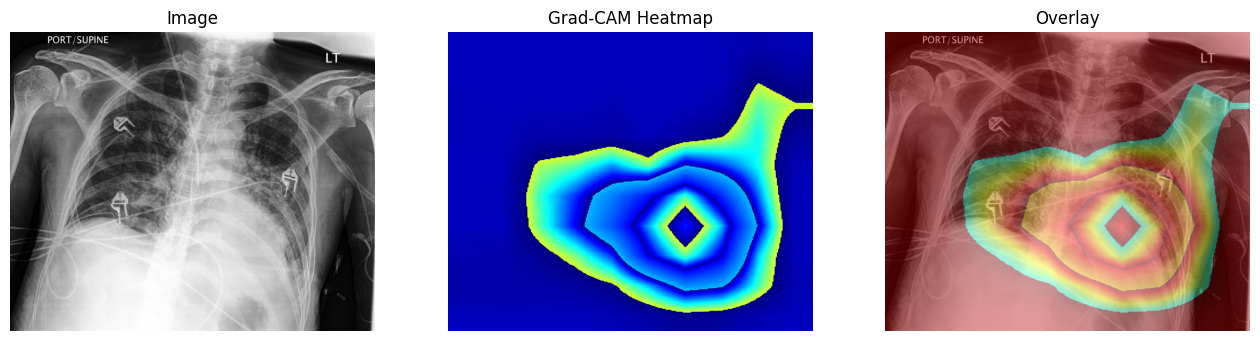

In [20]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Correct full image path
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

# ---------------------------
# Load image
# ---------------------------
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor_img = tensor_img.to(device)
model = model.to(device)

output = model(tensor_img)

# ---------------------------
# Grad-CAM hook (ConvNeXt)
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        # Forward hook collects activations
        target_layer.register_forward_hook(self.forward_hook)

        # Backward hook collects gradients
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        grads = self.gradients.mean(dim=[2,3], keepdim=True)
        cams = (grads * self.activations).sum(dim=1)[0]
        cams = torch.relu(cams)
        cams = cams / cams.max()
        return cams.detach().cpu().numpy()

# Use last block’s depthwise conv
target_layer = model.stage4[-1].dwconv
cam = GradCAM(model, target_layer)


# ---------------------------
# Forward → Predict class
# ---------------------------
output = model(tensor_img)
class_idx = output.argmax().item()
print("Predicted class index:", class_idx)

# ---------------------------
# Forward → Predict class
# ---------------------------
device = next(model.parameters()).device     # model device (cpu or cuda)
tensor_img = tensor_img.to(device)

output = model(tensor_img)
class_idx = output.argmax().item()
print("Predicted class index:", class_idx)

# ---------------------------
# Make heatmap visually nice
# ---------------------------
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# ---------------------------
# Show results
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


SEED 123


In [34]:
import torch

checkpoint = torch.load("/content/conv_seed_123_best_model (1).pth", map_location='cuda')

print(checkpoint["model_state_dict"].keys())


odict_keys(['features.0.0.weight', 'features.0.0.bias', 'features.0.1.weight', 'features.0.1.bias', 'features.1.0.layer_scale', 'features.1.0.block.0.weight', 'features.1.0.block.0.bias', 'features.1.0.block.2.weight', 'features.1.0.block.2.bias', 'features.1.0.block.3.weight', 'features.1.0.block.3.bias', 'features.1.0.block.5.weight', 'features.1.0.block.5.bias', 'features.1.1.layer_scale', 'features.1.1.block.0.weight', 'features.1.1.block.0.bias', 'features.1.1.block.2.weight', 'features.1.1.block.2.bias', 'features.1.1.block.3.weight', 'features.1.1.block.3.bias', 'features.1.1.block.5.weight', 'features.1.1.block.5.bias', 'features.1.2.layer_scale', 'features.1.2.block.0.weight', 'features.1.2.block.0.bias', 'features.1.2.block.2.weight', 'features.1.2.block.2.bias', 'features.1.2.block.3.weight', 'features.1.2.block.3.bias', 'features.1.2.block.5.weight', 'features.1.2.block.5.bias', 'features.2.0.weight', 'features.2.0.bias', 'features.2.1.weight', 'features.2.1.bias', 'feature

In [22]:
# final_convnext_explainability_fixed.py
import os
import pickle
import json
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import pandas as pd

# -----------------------------
# ========== SETTINGS =========
# -----------------------------
CHECKPOINT_PATH = "/content/conv_seed_123_best_model (1).pth"
IMAGE_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/"
HEATMAP_ROOT  = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

NUM_CLASSES     = 8
STEPS           = 30
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_PREFIX      = "convnext_explainability"

print("DEVICE:", DEVICE)

# -----------------------------
# ========== MODEL ============
# -----------------------------
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.pw1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pw2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = x.permute(0,2,3,1)
        x = self.pw1(x)
        x = self.act(x)
        x = self.pw2(x)
        x = x * self.gamma
        x = x.permute(0,3,1,2)
        return shortcut + x

class ConvNeXtCustom(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.stem = nn.Conv2d(3, 96, kernel_size=4, stride=4)
        self.stage1 = nn.Sequential(*[ConvNeXtBlock(96)  for _ in range(3)])
        self.down1  = nn.Conv2d(96, 192, kernel_size=2, stride=2)
        self.stage2 = nn.Sequential(*[ConvNeXtBlock(192) for _ in range(3)])
        self.down2  = nn.Conv2d(192, 384, kernel_size=2, stride=2)
        self.stage3 = nn.Sequential(*[ConvNeXtBlock(384) for _ in range(9)])
        self.down3  = nn.Conv2d(384, 768, kernel_size=2, stride=2)
        self.stage4 = nn.Sequential(*[ConvNeXtBlock(768) for _ in range(3)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(768, eps=1e-6),
            nn.Identity(),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.down1(x)
        x = self.stage2(x)
        x = self.down2(x)
        x = self.stage3(x)
        x = self.down3(x)
        x = self.stage4(x)
        x = x.mean([-2,-1])
        return self.classifier(x)

model = ConvNeXtCustom(num_classes=NUM_CLASSES)
ck = torch.load(CHECKPOINT_PATH, map_location="cpu")
model.load_state_dict(ck["model_state_dict"], strict=False)
model.to(DEVICE)
model.eval()

print("Model loaded.")

# -----------------------------
# ========== TRANSFORMS =======
# -----------------------------
norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])

transform_raw = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_input = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])

# -----------------------------
# ========== METRICS ==========
# -----------------------------
def average_drop(o, m): return max(0,(o-m)/(o+1e-6))
def increase_in_conf(o, m): return max(0,(m-o)/(o+1e-6))

def heatmap_entropy(h):
    h = h/h.sum()
    return -np.sum(h*np.log(h+1e-12))

def heatmap_sparsity(h):
    return 1 - (np.count_nonzero(h)/h.size)

def deletion_metric(model, img_raw, hm, steps=30):
    H,W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.ones(H*W, device=DEVICE)

    scores = []
    for s in range(steps):
        k = int((s+1)/steps * len(order))
        mask[order[:k]] = 0
        m2d = mask.view(H,W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        masked = raw * m3
        inp = norm(masked).unsqueeze(0)

        with torch.no_grad():
            scores.append(model(inp).max().item())

    return scores

def insertion_metric(model, img_raw, hm, steps=30):
    H,W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.zeros(H*W, device=DEVICE)
    blurred = torch.zeros_like(raw)

    scores = []
    for s in range(steps):
        k = int((s+1)/steps * len(order))
        mask[order[:k]] = 1

        m2d = mask.view(H,W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        new = blurred*(1-m3) + raw*m3
        inp = norm(new).unsqueeze(0)

        with torch.no_grad():
            scores.append(model(inp).max().item())

    return scores

# -----------------------------
# ========== MAIN LOOP ========
# -----------------------------
results = []
missing_hm = 0
missing_img = 0

patients = sorted([p for p in os.listdir(IMAGE_ROOT)
                   if "patient" in p.lower()])

for patient in tqdm(patients):
    img_path = os.path.join(IMAGE_ROOT, patient, "study1", "view1_frontal.jpg")
    if not os.path.exists(img_path):
        missing_img += 1
        continue

    # ---- AUTOFIND HEATMAP ----
    prefix = f"{patient}_study1_view1_frontal"
    candidates = [f for f in os.listdir(HEATMAP_ROOT) if f.startswith(prefix)]
    if len(candidates)==0:
        missing_hm += 1
        continue
    heatmap_path = os.path.join(HEATMAP_ROOT, candidates[0])

    # ---- Load image ----
    img_raw = transform_raw(Image.open(img_path).convert("RGB")).float()
    img_input = norm(img_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        orig_score = model(img_input).max().item()

    # ---- Load heatmap ----
    d = pickle.load(open(heatmap_path,"rb"))
    hm = d["map"]
    if torch.is_tensor(hm): hm = hm.cpu().numpy()
    while hm.ndim > 2: hm = hm.squeeze()

    if hm.max() != hm.min():
        hm = (hm-hm.min())/(hm.max()-hm.min())
    else:
        hm = np.zeros_like(hm)

    hm = np.array(Image.fromarray((hm*255).astype("uint8"))
                  .resize((224,224))) / 255.0

    hm_t = torch.tensor(hm, dtype=torch.float32)

    # ---- Masked image ----
    mask3 = hm_t.unsqueeze(0).expand_as(img_raw)
    masked_raw = img_raw * mask3
    masked_input = norm(masked_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        masked_score = model(masked_input).max().item()

    # ---- Metrics ----
    ad = average_drop(orig_score, masked_score)
    ic = increase_in_conf(orig_score, masked_score)
    ent = heatmap_entropy(hm)
    spr = heatmap_sparsity(hm)

    del_curve = deletion_metric(model, img_raw, hm, steps=STEPS)
    ins_curve = insertion_metric(model, img_raw, hm, steps=STEPS)

    results.append({
        "patient": patient,
        "avg_drop": ad,
        "inc_conf": ic,
        "entropy": ent,
        "sparsity": spr,
        "deletion": del_curve,
        "insertion": ins_curve
    })

print("Missing images:", missing_img)
print("Missing heatmaps:", missing_hm)
print("Processed:", len(results))

if len(results)==0:
    raise SystemExit("❌ No results found.")

# -----------------------------
# ========== SAVE RESULTS =====
# -----------------------------
df = pd.DataFrame(results)
df.to_pickle(f"{OUT_PREFIX}_results.pkl")
df.to_csv(f"{OUT_PREFIX}_results.csv", index=False)




DEVICE: cuda
Model loaded.


100%|██████████| 200/200 [05:30<00:00,  1.65s/it]

Missing images: 0
Missing heatmaps: 0
Processed: 200


In [23]:
summary = {
    "avg_drop_mean": float(df["avg_drop"].mean()),
    "avg_drop_std":  float(df["avg_drop"].std()),

    "inc_conf_mean": float(df["inc_conf"].mean()),
    "inc_conf_std":  float(df["inc_conf"].std()),

    "entropy_mean": float(df["entropy"].mean()),
    "entropy_std":  float(df["entropy"].std()),

    "sparsity_mean": float(df["sparsity"].mean()),
    "sparsity_std":  float(df["sparsity"].std()),

    "n_images": len(df)
}

# aggregate deletion/insertion curves
deletion_array  = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["deletion_curve_std"]  = deletion_array.std(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()
summary["insertion_curve_std"]  = insertion_array.std(axis=0).tolist()

with open(f"{OUT_PREFIX}_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", f"{OUT_PREFIX}_summary.json")
print("Summary:", {k: summary[k] for k in summary if "curve" not in k})



Saved summary to convnext_explainability_summary.json
Summary: {'avg_drop_mean': 0.5408158358459734, 'avg_drop_std': 0.050494759249842786, 'inc_conf_mean': 0.0, 'inc_conf_std': 0.0, 'entropy_mean': 9.636682463443389, 'entropy_std': 0.4842337319831815, 'sparsity_mean': 0.4110986328125, 'sparsity_std': 0.218719746384018, 'n_images': 200}


Predicted class index: 4


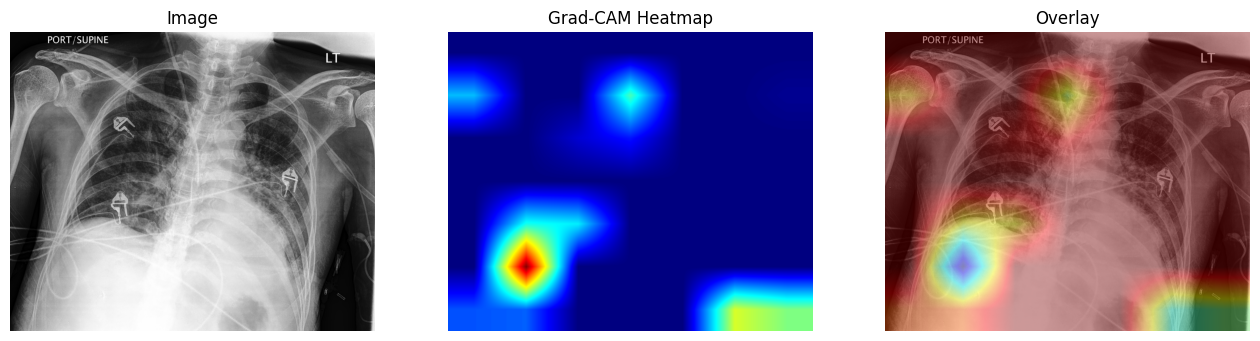

In [38]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Load Model
# ---------------------------
# IMPORTANT: Your model must be already loaded as "model"
# Example:
# model = ConvNeXtCustom(...)
# model.load_state_dict(torch.load(...))
# model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# ---------------------------
# Load Image
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0).to(device)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        # forward hook
        target_layer.register_forward_hook(self.forward_hook)

        # backward hook (PyTorch >= 2.0)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        # grad_output is a tuple, we need the gradient w.r.t. output
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        # GAP over gradients
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)

        # Weighted sum of activations
        cam = (weights * self.activations).sum(dim=1)[0]

        cam = torch.relu(cam)
        cam = cam / cam.max()

        return cam.detach().cpu().numpy()

# -----------------------------------------------------
# ConvNeXt target layer = LAST CONV block in stage4
# -----------------------------------------------------
target_layer = model.stage4[-1].dwconv  # <-- This is correct for Grad-CAM

cam = GradCAM(model, target_layer)

# ---------------------------
# Forward pass → prediction
# ---------------------------
output = model(tensor_img)
class_idx = output.argmax().item()

print("Predicted class index:", class_idx)

# ---------------------------
# Backward pass
# ---------------------------
model.zero_grad()
output[0, class_idx].backward()

heatmap = cam.generate(class_idx)

# ---------------------------
# Heatmap Processing
# ---------------------------
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# ---------------------------
# Visualization
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


SEED 42

In [25]:
import torch

checkpoint = torch.load("/content/conv_seed_42_best_model (1).pth", map_location='cuda')

print(checkpoint["model_state_dict"].keys())


odict_keys(['features.0.0.weight', 'features.0.0.bias', 'features.0.1.weight', 'features.0.1.bias', 'features.1.0.layer_scale', 'features.1.0.block.0.weight', 'features.1.0.block.0.bias', 'features.1.0.block.2.weight', 'features.1.0.block.2.bias', 'features.1.0.block.3.weight', 'features.1.0.block.3.bias', 'features.1.0.block.5.weight', 'features.1.0.block.5.bias', 'features.1.1.layer_scale', 'features.1.1.block.0.weight', 'features.1.1.block.0.bias', 'features.1.1.block.2.weight', 'features.1.1.block.2.bias', 'features.1.1.block.3.weight', 'features.1.1.block.3.bias', 'features.1.1.block.5.weight', 'features.1.1.block.5.bias', 'features.1.2.layer_scale', 'features.1.2.block.0.weight', 'features.1.2.block.0.bias', 'features.1.2.block.2.weight', 'features.1.2.block.2.bias', 'features.1.2.block.3.weight', 'features.1.2.block.3.bias', 'features.1.2.block.5.weight', 'features.1.2.block.5.bias', 'features.2.0.weight', 'features.2.0.bias', 'features.2.1.weight', 'features.2.1.bias', 'feature

In [26]:
# final_convnext_explainability_fixed.py
import os
import pickle
import json
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import pandas as pd

# -----------------------------
# ========== SETTINGS =========
# -----------------------------
CHECKPOINT_PATH = "/content/conv_seed_42_best_model (1).pth"
IMAGE_ROOT = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/"
HEATMAP_ROOT  = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXlocalize/gradcam_maps_val"

NUM_CLASSES     = 8
STEPS           = 30
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_PREFIX      = "convnext_explainability"

print("DEVICE:", DEVICE)

# -----------------------------
# ========== MODEL ============
# -----------------------------
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.pw1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pw2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = x.permute(0,2,3,1)
        x = self.pw1(x)
        x = self.act(x)
        x = self.pw2(x)
        x = x * self.gamma
        x = x.permute(0,3,1,2)
        return shortcut + x

class ConvNeXtCustom(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.stem = nn.Conv2d(3, 96, kernel_size=4, stride=4)
        self.stage1 = nn.Sequential(*[ConvNeXtBlock(96)  for _ in range(3)])
        self.down1  = nn.Conv2d(96, 192, kernel_size=2, stride=2)
        self.stage2 = nn.Sequential(*[ConvNeXtBlock(192) for _ in range(3)])
        self.down2  = nn.Conv2d(192, 384, kernel_size=2, stride=2)
        self.stage3 = nn.Sequential(*[ConvNeXtBlock(384) for _ in range(9)])
        self.down3  = nn.Conv2d(384, 768, kernel_size=2, stride=2)
        self.stage4 = nn.Sequential(*[ConvNeXtBlock(768) for _ in range(3)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(768, eps=1e-6),
            nn.Identity(),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.down1(x)
        x = self.stage2(x)
        x = self.down2(x)
        x = self.stage3(x)
        x = self.down3(x)
        x = self.stage4(x)
        x = x.mean([-2,-1])
        return self.classifier(x)

model = ConvNeXtCustom(num_classes=NUM_CLASSES)
ck = torch.load(CHECKPOINT_PATH, map_location="cpu")
model.load_state_dict(ck["model_state_dict"], strict=False)
model.to(DEVICE)
model.eval()

print("Model loaded.")

# -----------------------------
# ========== TRANSFORMS =======
# -----------------------------
norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                            std=[0.229,0.224,0.225])

transform_raw = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_input = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    norm
])

# -----------------------------
# ========== METRICS ==========
# -----------------------------
def average_drop(o, m): return max(0,(o-m)/(o+1e-6))
def increase_in_conf(o, m): return max(0,(m-o)/(o+1e-6))

def heatmap_entropy(h):
    h = h/h.sum()
    return -np.sum(h*np.log(h+1e-12))

def heatmap_sparsity(h):
    return 1 - (np.count_nonzero(h)/h.size)

def deletion_metric(model, img_raw, hm, steps=30):
    H,W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.ones(H*W, device=DEVICE)

    scores = []
    for s in range(steps):
        k = int((s+1)/steps * len(order))
        mask[order[:k]] = 0
        m2d = mask.view(H,W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        masked = raw * m3
        inp = norm(masked).unsqueeze(0)

        with torch.no_grad():
            scores.append(model(inp).max().item())

    return scores

def insertion_metric(model, img_raw, hm, steps=30):
    H,W = hm.shape
    flat = hm.flatten()
    order = np.argsort(-flat)

    raw = img_raw.clone().to(DEVICE)
    mask = torch.zeros(H*W, device=DEVICE)
    blurred = torch.zeros_like(raw)

    scores = []
    for s in range(steps):
        k = int((s+1)/steps * len(order))
        mask[order[:k]] = 1

        m2d = mask.view(H,W)
        m3 = m2d.unsqueeze(0).expand_as(raw)

        new = blurred*(1-m3) + raw*m3
        inp = norm(new).unsqueeze(0)

        with torch.no_grad():
            scores.append(model(inp).max().item())

    return scores

# -----------------------------
# ========== MAIN LOOP ========
# -----------------------------
results = []
missing_hm = 0
missing_img = 0

patients = sorted([p for p in os.listdir(IMAGE_ROOT)
                   if "patient" in p.lower()])

for patient in tqdm(patients):
    img_path = os.path.join(IMAGE_ROOT, patient, "study1", "view1_frontal.jpg")
    if not os.path.exists(img_path):
        missing_img += 1
        continue

    # ---- AUTOFIND HEATMAP ----
    prefix = f"{patient}_study1_view1_frontal"
    candidates = [f for f in os.listdir(HEATMAP_ROOT) if f.startswith(prefix)]
    if len(candidates)==0:
        missing_hm += 1
        continue
    heatmap_path = os.path.join(HEATMAP_ROOT, candidates[0])

    # ---- Load image ----
    img_raw = transform_raw(Image.open(img_path).convert("RGB")).float()
    img_input = norm(img_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        orig_score = model(img_input).max().item()

    # ---- Load heatmap ----
    d = pickle.load(open(heatmap_path,"rb"))
    hm = d["map"]
    if torch.is_tensor(hm): hm = hm.cpu().numpy()
    while hm.ndim > 2: hm = hm.squeeze()

    if hm.max() != hm.min():
        hm = (hm-hm.min())/(hm.max()-hm.min())
    else:
        hm = np.zeros_like(hm)

    hm = np.array(Image.fromarray((hm*255).astype("uint8"))
                  .resize((224,224))) / 255.0

    hm_t = torch.tensor(hm, dtype=torch.float32)

    # ---- Masked image ----
    mask3 = hm_t.unsqueeze(0).expand_as(img_raw)
    masked_raw = img_raw * mask3
    masked_input = norm(masked_raw).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        masked_score = model(masked_input).max().item()

    # ---- Metrics ----
    ad = average_drop(orig_score, masked_score)
    ic = increase_in_conf(orig_score, masked_score)
    ent = heatmap_entropy(hm)
    spr = heatmap_sparsity(hm)

    del_curve = deletion_metric(model, img_raw, hm, steps=STEPS)
    ins_curve = insertion_metric(model, img_raw, hm, steps=STEPS)

    results.append({
        "patient": patient,
        "avg_drop": ad,
        "inc_conf": ic,
        "entropy": ent,
        "sparsity": spr,
        "deletion": del_curve,
        "insertion": ins_curve
    })

print("Missing images:", missing_img)
print("Missing heatmaps:", missing_hm)
print("Processed:", len(results))

if len(results)==0:
    raise SystemExit("❌ No results found.")

# -----------------------------
# ========== SAVE RESULTS =====
# -----------------------------
df = pd.DataFrame(results)
df.to_pickle(f"{OUT_PREFIX}_results.pkl")
df.to_csv(f"{OUT_PREFIX}_results.csv", index=False)




DEVICE: cuda
Model loaded.


100%|██████████| 200/200 [05:26<00:00,  1.63s/it]

Missing images: 0
Missing heatmaps: 0
Processed: 200


In [27]:
summary = {
    "avg_drop_mean": float(df["avg_drop"].mean()),
    "avg_drop_std":  float(df["avg_drop"].std()),

    "inc_conf_mean": float(df["inc_conf"].mean()),
    "inc_conf_std":  float(df["inc_conf"].std()),

    "entropy_mean": float(df["entropy"].mean()),
    "entropy_std":  float(df["entropy"].std()),

    "sparsity_mean": float(df["sparsity"].mean()),
    "sparsity_std":  float(df["sparsity"].std()),

    "n_images": len(df)
}

# aggregate deletion/insertion curves
deletion_array  = np.stack(df["deletion"].values)
insertion_array = np.stack(df["insertion"].values)

summary["deletion_curve_mean"] = deletion_array.mean(axis=0).tolist()
summary["deletion_curve_std"]  = deletion_array.std(axis=0).tolist()
summary["insertion_curve_mean"] = insertion_array.mean(axis=0).tolist()
summary["insertion_curve_std"]  = insertion_array.std(axis=0).tolist()

with open(f"{OUT_PREFIX}_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary to", f"{OUT_PREFIX}_summary.json")
print("Summary:", {k: summary[k] for k in summary if "curve" not in k})



Saved summary to convnext_explainability_summary.json
Summary: {'avg_drop_mean': 0.0600813022247084, 'avg_drop_std': 0.07806657868546121, 'inc_conf_mean': 0.06582914315423077, 'inc_conf_std': 0.11114615775088323, 'entropy_mean': 9.636682463443389, 'entropy_std': 0.4842337319831815, 'sparsity_mean': 0.4110986328125, 'sparsity_std': 0.218719746384018, 'n_images': 200}


In [30]:
print(model)

ConvNeXtCustom(
  (stem): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  (stage1): Sequential(
    (0): ConvNeXtBlock(
      (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (pw1): Linear(in_features=96, out_features=384, bias=True)
      (act): GELU(approximate='none')
      (pw2): Linear(in_features=384, out_features=96, bias=True)
    )
    (1): ConvNeXtBlock(
      (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (pw1): Linear(in_features=96, out_features=384, bias=True)
      (act): GELU(approximate='none')
      (pw2): Linear(in_features=384, out_features=96, bias=True)
    )
    (2): ConvNeXtBlock(
      (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
      (pw1): Linear(in_features=96, out_features=384, bias=True)
      (act): GELU(approximate='none')
      (pw2): Linear(in_features=384, out_features=96, bias=True)
    )
  )
  (down1): Conv2d(96, 19

Predicted class index: 4


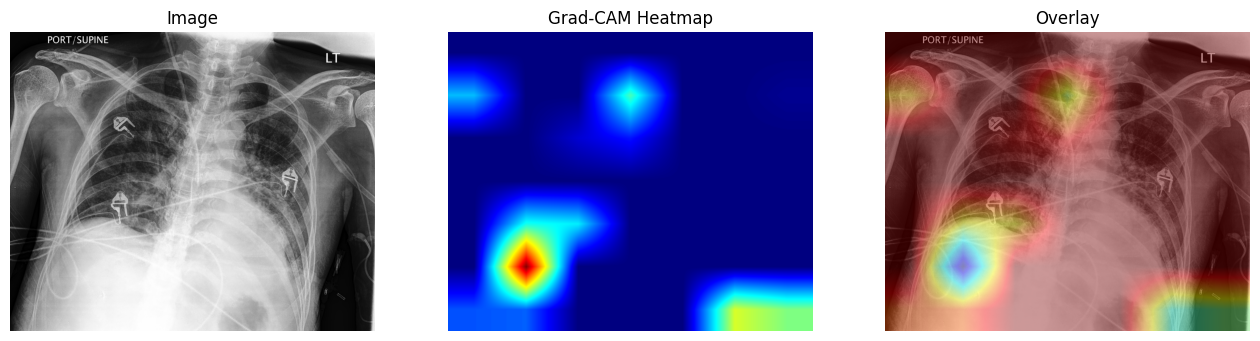

In [39]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# ---------------------------
# Load image
# ---------------------------
img_path = "/root/.cache/kagglehub/datasets/snikhilrao/chexlocalize-dataset/versions/1/chexlocalize_dataset/chexlocalize/CheXpert/val/patient64669/study1/view1_frontal.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tensor_img = transform(img).unsqueeze(0)

# ---------------------------
# Setup device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_img = tensor_img.to(device)
model = model.to(device)
model.eval()

# ---------------------------
# Grad-CAM class
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        # forward hook
        target_layer.register_forward_hook(self.forward_hook)

        # backward hook
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        # mean gradient across spatial dims
        grads = self.gradients.mean(dim=[2, 3], keepdim=True)
        cams = (grads * self.activations).sum(dim=1)[0]

        # ReLU
        cams = torch.relu(cams)
        cams = cams / cams.max()

        return cams.detach().cpu().numpy()

# ---------------------------
# IMPORTANT: Correct ConvNeXt layer
# ---------------------------
# This works for ConvNeXt tiny/small/base/large
# ---------------------------
# Correct Grad-CAM layer for ConvNeXtCustom
# ---------------------------
target_layer = model.stage4[-1].dwconv

cam = GradCAM(model, target_layer)


# ---------------------------
# Forward → Predict
# ---------------------------
output = model(tensor_img)
class_idx = output.argmax().item()
print("Predicted class index:", class_idx)

# ---------------------------
# Backward → compute gradients for Grad-CAM
# ---------------------------
model.zero_grad()
output[0, class_idx].backward()

# ---------------------------
# Generate heatmap
# ---------------------------
heatmap = cam.generate(class_idx)

# Resize to original image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay
overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# ---------------------------
# Visualize
# ---------------------------
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()
